# Refactoring temperature

Basic data and imports.

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Make designer.

In [5]:
import numpy as np
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

In [435]:
self = designer.generator

In [1009]:
%%time
import pyarrow.parquet as pq

table = pq.read_table('../../dgym-data/sizes.parquet')
sizes = torch.tensor(table[0].to_numpy())

CPU times: user 15.3 ms, sys: 793 µs, total: 16.1 ms
Wall time: 4.9 ms


In [1006]:
%%time
import torch

molecules = [deck[10].reactants[1]]
fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in molecules
]

queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries = queries,
    targets = self.fingerprints,
    progress = False,
    threshold = 0.0,
)

scores = torch.tensor(results.to_csr().A)

CPU times: user 0 ns, sys: 7.72 ms, total: 7.72 ms
Wall time: 6.29 ms


In [1010]:
scores += self.size_similarity(molecules, sizes)

In [1182]:
%%time
temperature = 0.05
probabilities = self.boltzmann(scores, temperature)
samples_idx = torch.multinomial(probabilities, 200)
samples = torch.gather(indices, 1, samples_idx).tolist()

CPU times: user 23.9 ms, sys: 787 µs, total: 24.7 ms
Wall time: 2.89 ms


In [1203]:
indices

tensor([[     0,      1,      2,  ..., 262333, 262334, 262335]])

In [1183]:
strict = False
generators = [
    self._generator_factory(sampler, molecule, strict=strict)
    for sampler, molecule in zip(samples, molecules)
]

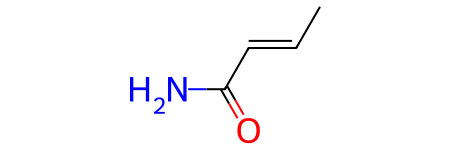

In [1202]:
next(generators[0])